# RTED-TDS Co-Sim

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted`` has attributes ``rted`` and ``dcopf``. The two attributes are the RTED model and standard DCOPF model.
The two model can be built by methods ``build_rted()`` and ``build_dcopf()``, respectively. The results can be accessed by method ``get_res()``, after successfully solved the ``rted`` or ``dcopf``.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, amtplotlib, scipy

## Import case

In [1]:
import andes
import numpy as np
from andes.interop.pandapower import to_pandapower, make_link_table, runopp_map
from andes.interop.pandapower import add_gencost, build_group_table
andes.config_logger(stream_level=20)

import pandas as pd
import pandapower as pp
from math import ceil, floor

import os

import matplotlib.pyplot as plt

import scipy.stats as stat

from jams import rted2, dcopf

Package version

In [2]:
print(andes.__version__)
print(pp.__version__)

1.6.5.post37.dev0+ge262cd38
2.8.0


Import ADNES case

In [3]:
# ss0 is used for PP conversion
dir_path = os.path.abspath('..')
case_path = '/case/ieee39_ev2.xlsx'
case = dir_path + case_path
ssa = andes.load(case,
                 setup=True,
                 no_output=True,
                 default_config=False)

Working directory: "/Users/jinningwang/Documents/work/andes/jwang/notes2"
> Loaded config from file "/Users/jinningwang/.andes/andes.rc"
> Loaded generated Python code in "/Users/jinningwang/.andes/pycode".
Parsing input file "/Users/jinningwang/Documents/work/andes/jwang/case/ieee39_ev2.xlsx"...
Input file parsed in 0.0671 seconds.
ACEc <1> added BusFreq <BusFreq_11> linked to bus <1>
System internal structure set up in 0.0247 seconds.


Set load as constant load.

In [4]:
ssa.PQ.config.p2p = 1
ssa.PQ.config.q2q = 1
ssa.PQ.config.p2z = 0
ssa.PQ.config.q2z = 0
ssa.PQ.pq2z = 0

Turn on ``numba`` can accelerate TDS.

In [5]:
ssa.config.numba

1

## Load synthetic

Create load data ``d_syn``, which is a ``DataFrame`` that have three columns: ``time``, ``s10``, ``h10``. ``time`` is by seconds, ``s10`` is scalar load.

ANDES total load is: 58.564 p.u.


Text(0.5, 0, 'Time [s]')

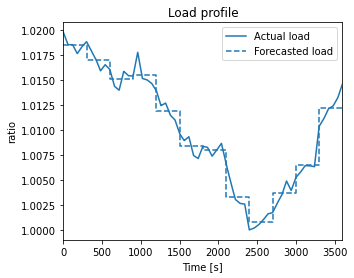

In [6]:
# --- get ANDES load ---
ptotal = ssa.PQ.as_df()['p0'].sum()
print('ANDES total load is:',ptotal.round(4),'p.u.')

# --- scale d_syn ---
ddata_path = '/case/d_syn2.csv'
ddata = dir_path + ddata_path
d_syn = pd.read_csv(ddata)

ratio = 4
# The equation is tuned for ieee39
# original: (d_syn['h10'] - d_syn['h10'].mean()) / d_syn['h10'].var() * ratio + 1
d_syn['s10'] = ratio*(d_syn['ph10'] - d_syn['ph10'].min()) / d_syn['h10'].var() + 1

# calculate expected load
step = 300
d_exp = d_syn.groupby(d_syn.index // step).mean().copy()
d_exp['time'] = range(0,3600,300)

fig_load, ax_load = plt.subplots(figsize=(5, 4))
ax_load.plot(d_syn['time'], d_syn['s10'], color='tab:blue', linestyle='-')
ystep = list(d_exp['s10'])
ystep.insert(0, d_exp['s10'].iloc[0])
ax_load.step(range(0,3900,300), ystep, color='tab:blue', linestyle='--')
ax_load.set_xlim([0, 3600])
ax_load.legend(['Actual load', 'Forecasted load'])
ax_load.set_title('Load profile')
ax_load.set_ylabel('ratio')
ax_load.set_xlabel('Time [s]')

## Setup ``ssp`` and ``ssd``

Convert ``ssa`` to pandapower net ``ssp``, add generator cost

The input cost array follow the matpower/pypower format, now only poly_cost is supported

In [7]:
# --- conversion ---
ssp = to_pandapower(ssa)

# set EV generator as uncontrollable
ssp.gen.controllable.iloc[9] = False

# add gen cost, G1-11. G10 EV, G11 Slack
linearcost = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1.5]

gen_cost = np.array([[2., 0., 0., 3., 0., 0., 0.]] * ssp.gen.shape[0])
gen_cost[:, 5] = linearcost  # c1

add_gencost(ssp, gen_cost)

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0889 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.916785548
2: |F(x)| = 0.1314169328
3: |F(x)| = 0.0003491192315
4: |F(x)| = 4.240441775e-09
Converged in 5 iterations in 0.0047 seconds.
Power flow results are consistent. Conversion is successful.


True

In [8]:
ssp.gen

,name,bus,p_mw,vm_pu,sn_mva,min_q_mvar,max_q_mvar,scaling,slack,in_service,slack_weight,type,controllable,min_p_mw,max_p_mw,power_station_trafo
0,PV_1,29,436.086385,1.035534,100.0,-58.084,153.180,1.0,False,True,0.0,None,True,0.0,1200.0,NaN
1,PV_2,30,645.999998,1.013246,100.0,-122.665,429.804,1.0,False,True,0.0,None,True,0.0,700.0,NaN
2,PV_3,31,724.999998,1.020528,100.0,-180.218,446.722,1.0,False,True,0.0,None,True,0.0,800.0,NaN
3,PV_4,32,651.999998,1.013430,100.0,-213.780,548.208,1.0,False,True,0.0,None,True,0.0,700.0,NaN
4,PV_5,33,520.000000,1.019109,100.0,-188.028,611.495,1.0,False,True,0.0,None,True,0.0,700.0,NaN
5,PV_6,34,690.000000,1.060000,100.0,-234.972,593.788,1.0,False,True,0.0,None,True,0.0,800.0,NaN
6,PV_7,35,590.000000,1.060000,100.0,-249.132,568.372,1.0,False,True,0.0,None,True,0.0,700.0,NaN
7,PV_8,36,330.000000,1.013996,100.0,-216.122,443.468,1.0,False,True,0.0,None,True,0.0,700.0,NaN
8,PV_9,37,780.000000,1.052803,100.0,-356.889,834.775,1.0,False,True,0.0,None,True,0.0,1000.0,NaN
9,PV_10,37,-50.000000,1.052803,100.0,0.000,0.000,1.0,False,True,0.0,None,False,-60.0,70.0,NaN


Build RTED instance ``ssd``

In [9]:
ssd = rted2()
ssd.from_andes(ssa)

# set EV generator as uncontrollable
ssd.gen.ctrl.iloc[9] = 0

# set EV geenrator as type2
ssd.def_type2(['PV_10'], [0], [0])

# set ramp5
ramp_hour = [120, 120, 60, 50, 70, 30, 34, 22, 20, 999, 240]
ssd.gen.ramp5 = np.array(ramp_hour) / 12 / ssd.mva

# set cost
ssd.cost.c1 = linearcost

# update p_pre from DCOPF results
ssd.set_p_pre()

# sovle the model
ssd.get_res()

Restricted license - for non-production use only - expires 2023-10-25


-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0028 seconds.
0: |F(x)| = 7.561234474
1: |F(x)| = 2.916785548
2: |F(x)| = 0.1314169328
3: |F(x)| = 0.0003491192315
4: |F(x)| = 4.240441775e-09
Converged in 5 iterations in 0.0040 seconds.
Power flow results are consistent. Conversion is successful.
GSF is consistent.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xe6f20cd2
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 51 rows and 2 columns
Presolve time: 0.00s
Presolved: 18 rows, 18 columns, 157 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   1.048117e+02   0.000000e+00      0s
      18    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.
No RegUp cost data (``cru`` in ``cost``), set to 0.
No RegDn cost data(``crd`` in ``cost``), set to 0.
No RegUp requirement data (``du``), set to 0.
No RegDn requirement data (``dd``), set to 0.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x475183bb
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [3e-01, 6e+01]
Presolve removed 114 rows and 26 columns
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 21 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   1.920596e-01   0.000000e+00      0s
       4    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve RTED.


,gen,pg,pru,prd,bu,bd
0,PV_1,12.000000,0.0,0.0,0.0,0.0
1,PV_2,6.986152,0.0,0.0,0.0,0.0
2,PV_3,7.950000,0.0,0.0,0.0,0.0
3,PV_4,5.867120,0.0,0.0,0.0,0.0
4,PV_5,7.000000,0.0,0.0,0.0,0.0
5,PV_6,4.800000,0.0,0.0,0.0,0.0
6,PV_7,7.000000,0.0,0.0,0.0,0.0
7,PV_8,3.935036,0.0,0.0,0.0,0.0
8,PV_9,0.525692,0.0,0.0,0.0,0.0
9,PV_10,-0.500000,0.0,0.0,0.0,0.0


Benchmark Standard DCOPF of ``ssd`` with ``ssp``

In [10]:
pp.rundcopp(ssp)
ppres = ssp.res_gen.copy()
ssdc = ssd.to_dcopf()
gb_res = ssdc.get_res()
ppres['p_mw(GB)'] = ssp.sn_mva * gb_res['pg'].values
print(f"pp cost={ssp.res_cost}, gb cost={ssd.res_cost}")
ppres

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xe6f20cd2
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 51 rows and 2 columns
Presolve time: 0.00s
Presolved: 18 rows, 18 columns, 157 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0064000e+01   1.048117e+02   0.000000e+00      0s
      18    6.0064000e+01   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.006400000e+01


Successfully solve DCOPF.


pp cost=6006.400000012521, gb cost=60.06399999999999


,p_mw,q_mvar,va_degree,vm_pu,p_mw(GB)
0,886.576387,91.721528,16.266469,1.0,1200.000000
1,543.350012,311.370989,5.568101,1.0,700.000000
2,644.116980,149.293426,9.793217,1.0,800.000000
3,544.373016,131.004236,10.678698,1.0,582.545346
4,544.442152,146.497277,10.469003,1.0,700.000000
5,626.016450,227.597221,13.699286,1.0,480.000000
6,540.850415,63.133957,16.635306,1.0,700.000000
7,463.364083,-27.033467,13.446885,1.0,392.952085
8,813.310504,116.236721,16.584439,1.0,50.902569
9,-50.000000,0.000000,16.584439,1.0,-50.000000


## Prepare

### Make link table

In [11]:
# --- link_table ---
ssa_key = make_link_table(ssa)

# --- add controllable in the link table ---
ssa_bus = ssa.Bus.as_df().reset_index().rename(columns={'uid':'bus_pp', 'idx':'bus_idx'})
ssp_gen = ssp.gen.reset_index().rename(columns={'index':'gen_pp', 'name':'stg_idx', 'controllable':'ctrl'})
ssa_key2 = pd.merge(left=ssa_key,
                    right=ssp_gen[['stg_idx', 'gen_pp', 'ctrl']],
                    on='stg_idx', how='left')

# --- device idx ---
ssa_dg_idx = ssa_key2.dg_idx.dropna().tolist()
ssa_syg_idx = ssa_key2.syg_idx.dropna().tolist()
ssa_gov_idx = ssa_key2.gov_idx.dropna().tolist()
ssa_stg_idx = ssa_key2.stg_idx.dropna().tolist()

# --- online and controllable device idx ---
ctrl_cond = ssa_key2.ctrl * ssa_key2.stg_u.astype(bool)
ssa_dg_idx_ctrl = ssa_key2.dg_idx[ctrl_cond].dropna().tolist()
ssa_syg_idx_ctrl = ssa_key2.syg_idx[ctrl_cond].dropna().tolist()
ssa_gov_idx_ctrl = ssa_key2.gov_idx[ctrl_cond].dropna().tolist()
ssa_stg_idx_ctrl = ssa_key2.stg_idx[ctrl_cond].dropna().tolist()

# fill NaN with False
ssa_key2.fillna(value=False, inplace=True)

ssa_key2

,stg_name,stg_u,stg_idx,bus_idx,dg_idx,syg_idx,exc_idx,gov_idx,bus_name,gammap,gammaq,gen_pp,ctrl
0,PV_1,1.0,PV_1,30,False,GENROU_1,IEEEX1_1,TGOV1_1,GEN30,1.0,1.0,0,True
1,PV_2,1.0,PV_2,31,False,GENROU_2,IEEEX1_2,TGOV1_2,GEN31,1.0,1.0,1,True
2,PV_3,1.0,PV_3,32,False,GENROU_3,IEEEX1_3,TGOV1_3,GEN32,1.0,1.0,2,True
3,PV_4,1.0,PV_4,33,False,GENROU_4,IEEEX1_4,TGOV1_4,GEN33,1.0,1.0,3,True
4,PV_5,1.0,PV_5,34,False,GENROU_5,IEEEX1_5,TGOV1_5,GEN34,1.0,1.0,4,True
5,PV_6,1.0,PV_6,35,False,GENROU_6,IEEEX1_6,TGOV1_6,GEN35,1.0,1.0,5,True
6,PV_7,1.0,PV_7,36,False,GENROU_7,IEEEX1_7,TGOV1_7,GEN36,1.0,1.0,6,True
7,PV_8,1.0,PV_8,37,False,GENROU_8,IEEEX1_8,TGOV1_8,GEN37,1.0,1.0,7,True
8,PV_9,1.0,PV_9,38,False,GENROU_9,IEEEX1_9,TGOV1_9,GEN38,1.0,1.0,8,True
9,Slack_10,1.0,Slack_10,39,False,GENROU_10,IEEEX1_10,TGOV1_10,GEN39,1.0,1.0,10,True


### Define functions used in loop

In [12]:
# --- def functions ---
def get_pe(ssa, gov_idx, dg_idx, ssa_key2):
    """Get the active power (TurbineGov/DG) after TDS, a DataFrame"""
    # TODO: may need to sum the power of same StaticGen
    # --- TurbineGov --- 
    pe_syg = ssa.TurbineGov.get(src='pout', idx=gov_idx, attr='v')
    # --- DG ---
    Ip_dg = ssa.DG.get(src='Ipout_y', idx=dg_idx, attr='v')
    v_dg = ssa.DG.get(src='v', idx=dg_idx, attr='v')
    pe_dg = Ip_dg*v_dg
    # --- out ---
    pe = pd.DataFrame()
    pe['idx'] = gov_idx + dg_idx
    pe['pe'] = np.concatenate((pe_syg, pe_dg))
    ldf = pd.merge(left=ssa_key2.rename(columns={'dg_idx':'idx'}),
         right=pe, how='right', on='idx')
    rdf = pd.merge(left=ssa_key2.rename(columns={'gov_idx':'idx'}),
             right=pe, how='right', on='idx')
    pe['stg_idx'] = ldf['stg_idx'].fillna('') + rdf['stg_idx'].fillna('')
    return pe

def dp_calc(d_syn, idx_ed, intv_ed):
    """Calc SFR requirements, scalars, ``dpd_u``and ``dpd_d``, and load forecasted value ``load_exp``"""
    load = d_syn['s10'].iloc[idx_ed*intv_ed:(idx_ed*intv_ed + intv_ed)]
    load_exp = load.mean()
    # TODO: check if the estimation is reasonable
    load_ci = stat.t.interval(alpha=0.95, df=len(load)-1, loc=np.mean(load), scale=stat.sem(load))
    load_d = abs(load_ci[0] - load_exp)
    load_u = abs(load_ci[1] - load_exp)
    return load_u, load_d, load_exp

## Define param

In [13]:
# --- constants ---
t_total = 3600    # 3600s

intv_ed = 300  # RTED interval, 300s
intv_agc = 4    # AGC interval, 4s
intv_pq = 1     # PQ interval, 1s; alter load and AGC
intv_step = 100 # step change interval; smooth the setpoitns

n_ed = int(t_total/intv_ed)
n_agc = int(intv_ed/intv_agc)
n_pq = int(intv_agc/intv_pq)
n_step = floor(intv_step/intv_agc)

# --- vars ---
# AGC table
agc_table = ssp.gen[['name']].rename(columns={'name':'stg_idx'})
agc_table['paux'] = 0
agc_res = agc_table[['stg_idx']].copy()

# ACE vars
ACE_integral = 0
ACE_raw = 0
Kp = 0.001 # 0.05
Ki = 0.001
ace_res = pd.DataFrame()

# initial load
ssa_p0 = ssa.PQ.p0.v.copy()
ssa_q0 = ssa.PQ.q0.v.copy()
ssa_pq_idx = ssa.PQ.idx.v
ssa_p0_sum = ssa_p0.sum()

## Loop

In the loop, there are mainly X parts:

- interval RTED: run DCOPF (``ssd.mdl``), run ACOPF(``ssp``), 

- interval AGC: do AGC, do dispatch with smooth setpoints

- interval PQ: alter load, run TDS(``ssa.TDS``)

Notes:

- The setpoints for DG are coded but not verified yet.

- After the development of ANDES control room, the dispatch and AGC part can be refactored.

- interface variables: ``DG.pmx``: DPV profile, ``DG.pref0``: setpoints, ``DG.pext0``: AGC

- ACOPF in pandapower considered generator limtis of ramping and SFR reserve

In [14]:
# Reserve some capacity to avoid TDS crush
ssp.gen.max_p_mw = ssp.gen.max_p_mw * 1

# store original generator data
ssp_gen0 = ssp.gen.copy()

for end_time in range(400):  # t_total
    # --- interval RTED ---
    if end_time % intv_ed == 0:
        idx_ed = end_time // intv_ed
        # --- Load update ---
        du, dd, load_exp = dp_calc(d_syn, idx_ed, intv_ed)
        ssp.load['p_mw'] = ssa_p0 * load_exp * ssp.sn_mva
        ssp.load['q_mvar'] = ssa_q0 * load_exp * ssp.sn_mva
        ssd.load['p0'] = ssa_p0 * load_exp
        # reset initial setpoints as the DCOPF results
        ssd.set_p_pre()

        # --- RTED, update gen limits after SFR ---
        if end_time > 0:
            # get pe from TDS and sort
            pe_tds = get_pe(ssa, ssa_gov_idx, ssa_dg_idx, ssa_key2)
            pe_tds = pe_tds.merge(ssa_key2, on='stg_idx',
                                  how='right').groupby('stg_idx', as_index=False).sum()
            p_pre = pe_tds['pe'].tolist()
        else:
            # DCOPF results as the initial previous setpoints
            p_pre = ssd.gen.p_pre.tolist()

        # TODO: INPUT cost and ramp, ramp should be p.u.
        ssd.def_sfr(du=du, dd=dd)

        # build and solve the RTED-DC
        dcres = ssd.get_res()  # get RTED-DC resutls
        # TODO: Integrate EV; send SFR back to EV

        # Reserve SFR and ramp from Generator limits in ``ssp``
        ssp_gen = pd.merge(left=ssp.gen.rename(columns={'name': 'stg_idx'}),
                           right=dcres.rename(columns={'gen': 'stg_idx'}),
                           on='stg_idx', how='left')
        # SFR limits
        ssp_gen['max_sfr'] = ssp_gen.max_p_mw - ssp_gen.pru * ssp.sn_mva
        ssp_gen['min_sfr'] = ssp_gen.min_p_mw + ssp_gen.prd * ssp.sn_mva
        # ramp limits
        ssp_gen['max_ramp'] = ssp.sn_mva * (np.array(p_pre) + np.array(ssd.gen.ramp5))
        ssp_gen['min_ramp'] = ssp.sn_mva * (np.array(p_pre) - np.array(ssd.gen.ramp5))
        # alter generator limits
        ssp.gen.max_p_mw = ssp_gen[['max_sfr', 'max_ramp']].min(axis=1)
        ssp.gen.min_p_mw = ssp_gen[['min_sfr', 'min_ramp']].max(axis=1)

        # --- ACOPF, update setpoints ---
        # store setpoints
        if end_time > 0:
            p0 = ssp_res['p'].values  # store setpoints
        else:
            p0 = [0] * ssa_key2.shape[0]

        # run ACOPF
        ssp_res = runopp_map(ssp, ssa_key)  # ACOPF resutls
        ssp_res['p0'] = p0                  # last setpoints
        ssp_res.fillna(False, inplace=True)  # Fill NA wil False

        # reset Generator limtis
        ssp.gen.max_p_mw = ssp_gen0.max_p_mw
        ssp.gen.min_p_mw = ssp_gen0.min_p_mw

    # --- interval AGC ---
    ace_gain = 1
    if end_time % intv_agc == 0:
        idx_agc = end_time // intv_agc - idx_ed * n_agc
        # --- AGC allocation, with a power cap ---
        ACE_input = min(ACE_raw, dcres.pru.sum())
        if ACE_raw >= 0:
            ACE_input = min(ACE_raw, dcres.pru.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bu.values
        else:
            ACE_input = max(ACE_raw, -1 * dcres.prd.sum())
            agc_table['paux'] = ACE_input * ace_gain * dcres.bd.values
        agc_res[f'{end_time}'] = agc_table['paux']
        ace_data = [end_time, ACE_raw, dcres.pru.sum(),
                    -1*dcres.prd.sum(), ACE_input]
        ace_new = pd.DataFrame([ace_data], columns=['time', 'ace', 'up', 'dn', 'in'])
        ace_res = pd.concat([ace_res, ace_new])

        # --- Do AGC ---
        # a.SynGen
        agc_syg = pd.merge(left=agc_table,
                           right=ssa_key2,
                           on='stg_idx', how='right')
        agc_syg['paux2'] = agc_syg.paux * agc_syg.gammap
        cond_gov = agc_syg.ctrl * agc_syg.gov_idx.astype(bool)
        agc_gov = agc_syg.gov_idx[cond_gov].tolist()
        ssa.TurbineGov.set(src='paux0', idx=agc_gov, attr='v',
                           value=agc_syg.paux2.values)
        # b.DG
        agc_dg = pd.merge(left=agc_table,
                          right=ssa_key2,
                          on='stg_idx', how='right')
        agc_dg['paux2'] = agc_dg.paux * agc_dg.gammap
        cond_dg = agc_dg.ctrl * agc_dg.dg_idx.astype(bool)
        agc_dg_idx = agc_dg.dg_idx[cond_dg].tolist()
        ssa.DG.set(src='pext0', idx=agc_dg_idx, attr='v',
                   value=agc_dg.paux2.values)

        # --- smooth setpoints ---
        if idx_ed == 0:
            ssp_res['pref'] = ssp_res['p']
        else:
            if idx_agc == 0:
                # only record the pe from TDS in the first AGC interval
                copy = ssp_res.merge(right=pe_tds[['pe', 'stg_idx']], on='stg_idx', how='left')
                ssp_res['pe_tds'] = copy.pe
            idx_step = min((end_time - idx_ed * intv_ed) // intv_agc + 1, n_step)
            ssp_res['pref_step'] = ssp_res.p - ssp_res.pe_tds
            # smooth change threshold: 0.1
            large_index = ssp_res['pref_step'][abs(ssp_res['pref_step']) > 0.1].index
            ssp_res['pref_delta'] = ssp_res['pref_step']
            ssp_res['pref_delta'].iloc[large_index] = ssp_res['pref_step'].iloc[large_index] / n_step * idx_step
            ssp_res['pref'] = ssp_res.pe_tds + ssp_res.pref_delta
        # update SynGen setpoints
        cond_gov = ssp_res.controllable * ssp_res.gov_idx.astype(bool)
        ssa.TurbineGov.set(src='pref0', idx=ssp_res.gov_idx[cond_gov].tolist(),
                           attr='v', value=ssp_res.pref[cond_gov].values)
        # update DG setpoints
        cond_dg = ssp_res.controllable * ssp_res.dg_idx.astype(bool)
        ssa.DG.set(src='pref0', idx=ssp_res.dg_idx[cond_dg].tolist(),
                   attr='v', value=ssp_res.pref[cond_dg].values)

    # --- intv_pq: alter load, run TDS ---
    if end_time == 0:
        # Initially, alter StaticGen: p0 and q0, RUN power flow
        stg_opf_idx = ssp_res.stg_idx[ssp_res.controllable].tolist()
        stg_opf_val = ssp_res.p[ssp_res.controllable].tolist()
        ssa.StaticGen.set(src='p0', idx=stg_opf_idx, attr='v', value=stg_opf_val)
        ssa.PQ.set(src='p0', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='q0', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])
        ssa.PFlow.run()
    else:
        # Otherwise, alter Ppf and Qpf
        ssa.PQ.set(src='Ppf', idx=ssa_pq_idx, attr='v',
                   value=ssa_p0 * d_syn['s10'].iloc[end_time])
        ssa.PQ.set(src='Qpf', idx=ssa_pq_idx, attr='v',
                   value=ssa_q0 * d_syn['s10'].iloc[end_time])

    # RUN TDS
    ssa.TDS.config.tf = end_time
    ssa.TDS.run()
    # ACE calculation
    ACE_integral = ACE_integral + ssa.ACEc.ace.v.sum()
    ACE_raw = -(Kp*ssa.ACEc.ace.v.sum() + Ki*ACE_integral)

    # ACE_raw = 0  # delete when run TDS
    # break loop if TDS run into error
    if ssa.exit_code != 0:
        raise ValueError(f"TDS error! Exit with {ssa.exit_code}, end at {end_time}s.")


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0xdbc25ad8
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 51 rows and 2 columns
Presolve time: 0.00s
Presolved: 18 rows, 18 columns, 157 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1146513e+01   1.060594e+02   0.000000e+00      0s
      18    6.1146513e+01   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.114651339e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0xb56b96f5
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [5e-05, 6e+01]
Presolve removed 114 rows and 26 columns
Presolve time: 0.01s
Presolved: 3 rows, 7 columns, 21 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1146513e+01   1.920596e-01   0.000000e+00      0s
       4    6.1146513e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.114651339e+01


Successfully solve RTED.
ACOPF failed, DCOPF is used instead.
-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: On
   Sparse solver: KLU
 Solution method: NR method
Numba compilation initiated with caching.
Power flow initialized in 0.0059 seconds.
0: |F(x)| = 9.408528327
1: |F(x)| = 2.910403163
2: |F(x)| = 0.141821114
3: |F(x)| = 0.0004356531697
4: |F(x)| = 7.492782395e-09
Converged in 5 iterations in 0.0042 seconds.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-0 s.
Fixed step size: h=33.33 ms. Shrink if not converged.
Numba compilation initiated with caching.
GENROU (xl <= xd2) out of typical upper limit.

   idx     | values | limit
-----------+--------+------
 GENROU_1  | 0.012  | 0.001
 GENROU_2  | 0.042  | 0.036
 GENROU_3  | 0.036  | 0.003
 GENROU_4  | 0.025  | 0.001
 GENROU_5  | 0.050  | 0.001
 GENROU

  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0007 seconds.
TimeSeries does not contain any time stamp.

-> Time Domain Simulation Summary:
Sparse Solver: KLU
Simulation time: 0.0-1 s.
Fixed step size: h=33.33 ms. Shrink if not converged.


  0%|          | 0/100 [00:00<?, ?%/s]

Current step size is zero. Integration is not permitted.
Simulation completed in 0.0469 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0378 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0392 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0517 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0532 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0540 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0561 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0876 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0865 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0956 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1073 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1017 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0574 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0526 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0554 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0583 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0577 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0661 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0646 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0699 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0803 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0811 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0843 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0824 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0743 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0757 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0733 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0889 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0950 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0918 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0843 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0842 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0811 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0866 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0898 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0866 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0978 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0855 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0975 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0810 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1150 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0986 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0867 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0935 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0858 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0841 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0967 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0891 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0943 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0983 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1045 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0819 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0474 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0542 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0750 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0656 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1033 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0982 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0992 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1004 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0777 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0805 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0829 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0935 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0976 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0853 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0877 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0676 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0848 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0936 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0864 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0920 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0998 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0929 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0828 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1240 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0850 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1046 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0887 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1082 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0844 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0941 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0838 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0925 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0783 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1093 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1001 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1008 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0786 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1094 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0960 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0828 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0906 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0834 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1027 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1024 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1066 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0886 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0919 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1096 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0921 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0787 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0929 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0957 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0924 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0899 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0977 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0915 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0949 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0970 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0879 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1182 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1172 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0990 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0862 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1023 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1092 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0933 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0938 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0961 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0937 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0907 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0954 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0840 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0928 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0974 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0846 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0811 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1078 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1050 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0864 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1089 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0924 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1103 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.1083 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0875 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0696 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0674 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0662 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0593 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0640 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0539 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0520 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0686 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0641 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0692 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0680 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0910 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0594 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0672 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0726 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0673 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0666 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0691 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0627 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0846 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0643 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0806 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0687 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0670 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0472 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0433 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0389 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0393 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0447 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0449 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0378 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0450 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0442 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0386 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0448 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0368 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0439 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0371 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0365 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0370 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0436 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0382 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0432 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0381 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0429 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0428 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0375 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0371 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0419 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0383 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0478 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0399 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0371 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0682 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0461 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0457 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0390 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0459 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0403 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0388 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0492 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0551 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0460 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0385 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0443 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0418 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0379 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0431 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0374 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0421 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0414 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0357 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0428 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0435 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0364 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0438 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0369 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0441 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0380 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0423 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0366 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0338 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0357 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0420 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0377 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0471 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0384 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0434 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0367 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0400 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0343 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0406 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0353 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0424 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0371 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0446 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0363 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0430 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0336 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0422 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0352 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0416 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0355 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0351 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0409 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0372 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0410 seconds.


  0%|          | 0/100 [00:00<?, ?%/s]

Simulation completed in 0.0357 seconds.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


Successfully build DCOPF model.


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 69 rows, 11 columns and 597 nonzeros
Model fingerprint: 0x1f878dfa
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [4e-01, 6e+01]
Presolve removed 51 rows and 2 columns
Presolve time: 0.00s
Presolved: 18 rows, 18 columns, 157 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1059278e+01   1.059589e+02   0.000000e+00      0s
      18    6.1059278e+01   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.105927785e+01


Successfully solve DCOPF.
Successfully set p_pre from DCOPF results.


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[arm])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 117 rows, 33 columns and 685 nonzeros
Model fingerprint: 0x8152387a
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [5e-01, 2e+01]
  RHS range        [1e-04, 6e+01]
Presolve removed 114 rows and 26 columns
Presolve time: 0.00s
Presolved: 3 rows, 7 columns, 21 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.1059278e+01   1.920596e-01   0.000000e+00      0s
       4    6.1059278e+01   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.00 seconds (0.00 work units)
Optimal objective  6.105927785e+01


Successfully solve RTED.


OPFNotConverged: Optimal Power Flow did not converge!

[Text(0.5, 51.00000000000006, 'Deviation [p.u.]'), Text(761.8, 0.5, '')]

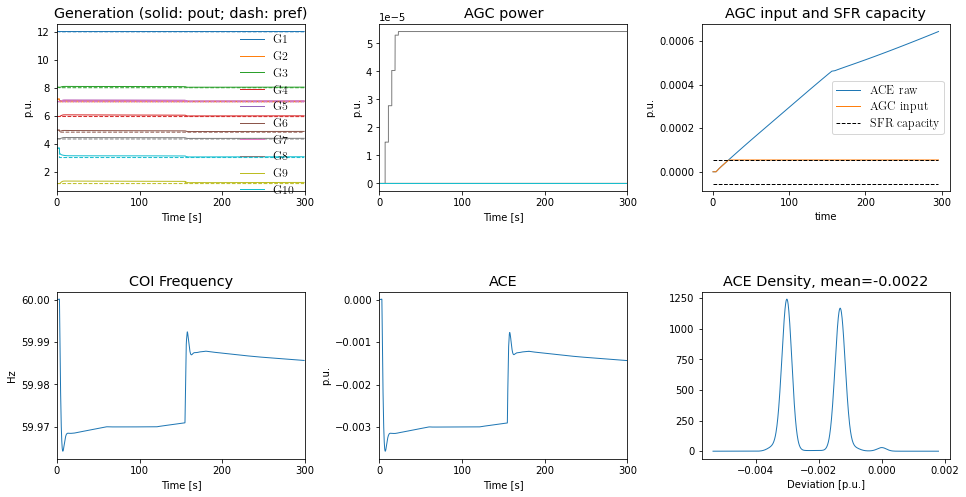

In [16]:
# color=['tab:blue', 'tab:orange', 'tab:green',
#        'tab:red', 'tab:purple']
right=end_time

fig_gen, ax_gen = plt.subplots(2, 3, figsize=(16, 8))
plt.subplots_adjust(left=None, bottom=None, right=None,
                    top=None, wspace=0.3, hspace=0.6)

yheader = [f'G{i}' for i in range(1,11)]

ssa.TDS.plt.plot(ssa.TGOV1N.pout,
                 linestyles=['-'],
                   yheader=yheader,
                   legend=True, show=False, right=right,
                   title=r'Generation (solid: pout; dash: pref)',
                   ylabel='p.u.',
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.pref,
                 legend=False, show=False, right=right,
                   linestyles=['--'],
                   fig=fig_gen, ax=ax_gen[0, 0])

ssa.TDS.plt.plot(ssa.TGOV1N.paux,
                linestyles=['-'],
                yheader=yheader,
                legend=False, show=False, right=right,
                title=r'AGC power',
                ylabel='p.u.',
                fig=fig_gen, ax=ax_gen[0, 1])

ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='ace',
            title=f'AGC input and SFR capacity')
ace_res.plot(linewidth=1,
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='in',)
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='up')
ace_res.plot(linewidth=1, color='k', linestyle='--',
            fig=fig_gen, ax=ax_gen[0, 2],
            x='time', y='dn')
ax_gen[0, 2].set_ylabel('p.u.')
ax_gen[0, 2].legend(['ACE raw', 'AGC input', 'SFR capacity'])

ssa.TDS.plt.plot(ssa.COI.omega,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 ytimes=60,
                 title=r'COI Frequency',
                 ylabel='Hz',
                 fig=fig_gen, ax=ax_gen[1, 0])

ssa.TDS.plt.plot(ssa.ACEc.ace,
                 legend=False, show=False, right=right,
                 linestyles=['-'],
                 title=r'ACE',
                 ylabel='p.u.',
                 fig=fig_gen, ax=ax_gen[1, 1])

font = {'family' : 'TimesNewRoma',
        'weight' : '1',
        'size'   : 12}

plt.rc('font', **font)

ace_tds = ssa.dae.ts.y[:, ssa.ACEc.ace.a].reshape(-1).copy()
ace_df = pd.DataFrame()
ace_df['ace'] = ace_tds
ace_df.plot(kind='kde', legend=False, linewidth=1,
            fig=fig_gen, ax=ax_gen[1, 2],
            title=f'ACE Density, mean={ace_df.ace.mean().round(4)}')
ax_gen[1, 2].set(xlabel='Deviation [p.u.]', ylabel='')